### Import Libraries

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm, skew

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb


%matplotlib inline
color = sns.color_palette()
sns.set_style('darkgrid')

### Load Data

In [2]:
train = pd.read_csv('https://raw.githubusercontent.com/AdamShafi92/house-prices_simple/main/data/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/AdamShafi92/house-prices_simple/main/data/train.csv')

train.drop('Id',axis=1,inplace=True)
test.drop('Id',axis=1,inplace=True)

### EDA

In [3]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train.shape

(1460, 80)

In [5]:
train.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
MSSubClass         0
dtype: int64

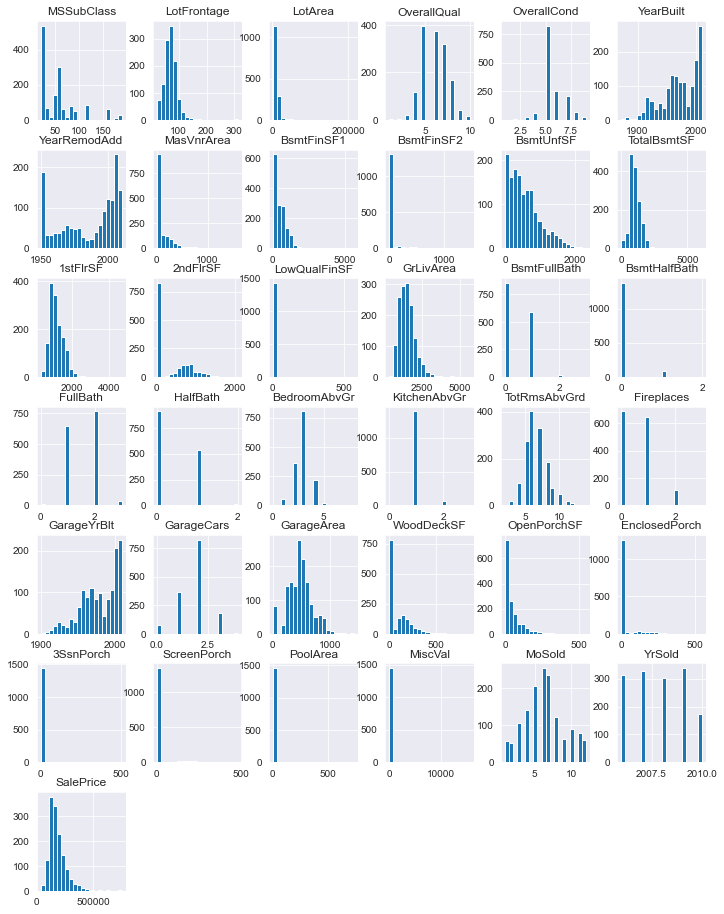

In [6]:
train.hist(figsize=(12,16),bins=20);

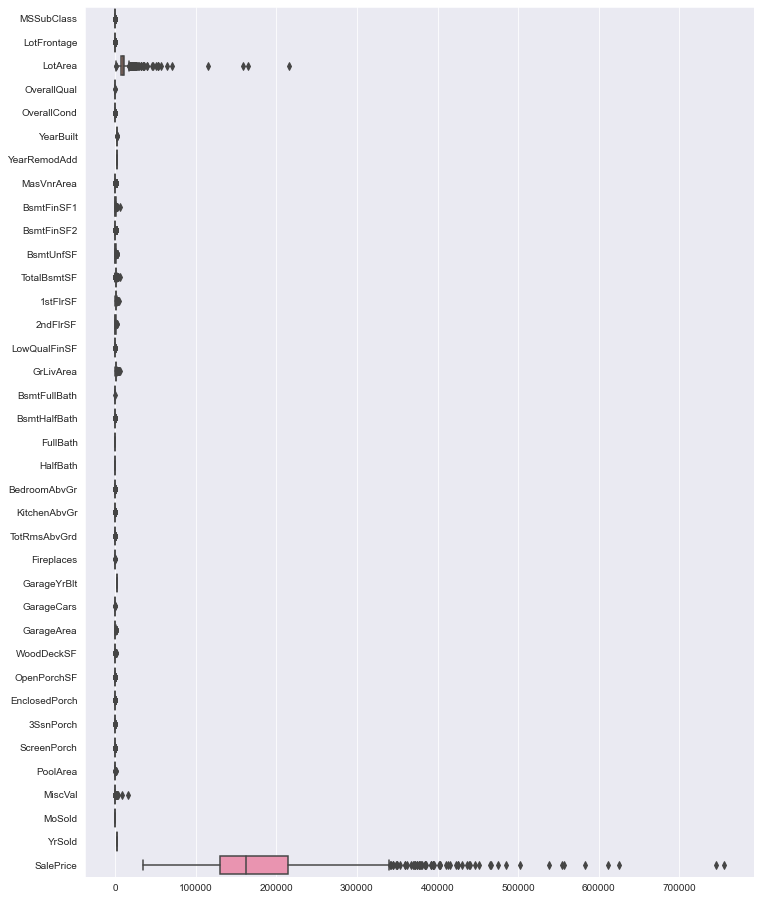

In [7]:
fig, ax = plt.subplots(figsize=(12,16))
sns.boxplot(data = train, orient='h')
plt.show()

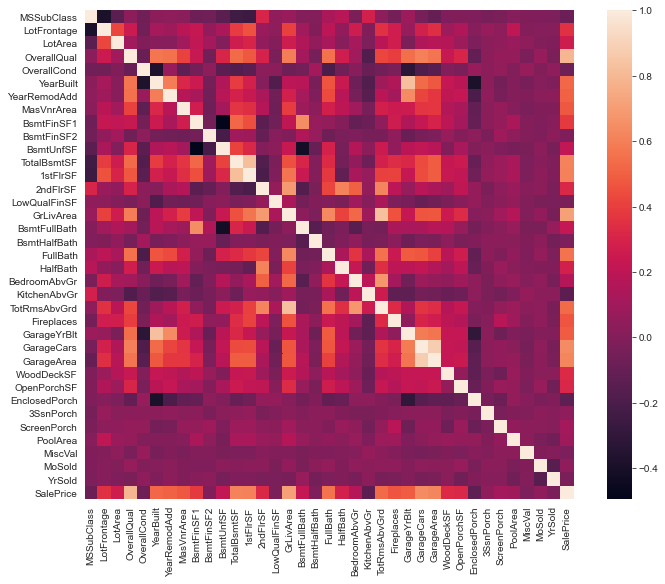

In [8]:
plt.subplots(figsize=(12,9))
sns.heatmap(train.corr(), vmax=1, square=True)
plt.show()

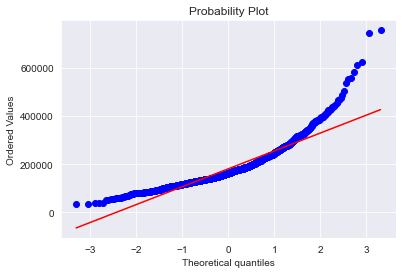

In [9]:
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

In [10]:
numeric_feats = train.dtypes[train.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness = skewness.drop('SalePrice',axis=0)
skewness.head(10)

,Skew
MiscVal,24.451640
PoolArea,14.813135
LotArea,12.195142
3SsnPorch,10.293752
LowQualFinSF,9.002080
KitchenAbvGr,4.483784
BsmtFinSF2,4.250888
ScreenPorch,4.117977
BsmtHalfBath,4.099186
EnclosedPorch,3.086696


### Cleaning

In [11]:
# Outliers

train = train.drop(train[(train['GrLivArea']>4000) & 
                         (train['SalePrice']<300000)]
                   .index)

X_train = train.drop('SalePrice',axis=1)
y_train = np.log1p(train["SalePrice"])

# Missing Values

none_cols = ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageType'
             ,'GarageFinish','GarageQual','GarageCond','BsmtQual', 'BsmtCond', 
             'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2','MasVnrType','MSSubClass']

X_train[none_cols] = X_train[none_cols].fillna("None")

zero_cols = ['GarageYrBlt', 'GarageArea', 'GarageCars','BsmtFinSF1', 
          'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 
          'BsmtHalfBath','MasVnrArea']

X_train[zero_cols] = X_train[zero_cols].fillna(0)


X_train["LotFrontage"] = X_train.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

X_train["Functional"] = X_train["Functional"].fillna("Typ")

X_train['MSZoning'] = X_train['MSZoning'].fillna(X_train['MSZoning'].mode()[0])
X_train['Electrical'] = X_train['Electrical'].fillna(X_train['Electrical'].mode()[0])
X_train['KitchenQual'] = X_train['KitchenQual'].fillna(X_train['KitchenQual'].mode()[0])
X_train['Exterior1st'] = X_train['Exterior1st'].fillna(X_train['Exterior1st'].mode()[0])
X_train['Exterior2nd'] = X_train['Exterior2nd'].fillna(X_train['Exterior2nd'].mode()[0])
X_train['SaleType'] = X_train['SaleType'].fillna(X_train['SaleType'].mode()[0])

# drop cols

X_train = X_train.drop(['Utilities'], axis=1)

# data type

X_train['MSSubClass'] = X_train['MSSubClass'].astype(str)
X_train['OverallCond'] = X_train['OverallCond'].astype(str)
X_train['YrSold'] = X_train['YrSold'].astype(str)
X_train['MoSold'] = X_train['MoSold'].astype(str)

# Adding total sqfootage feature 
X_train['TotalSF'] = X_train['TotalBsmtSF'] + X_train['1stFlrSF'] + X_train['2ndFlrSF']

In [12]:
skewed_feats

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.666326
OpenPorchSF       2.361912
LotFrontage       2.160866
SalePrice         1.880941
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
BsmtUnfSF         0.919323
2ndFlrSF          0.812194
OverallCond       0.692355
TotRmsAbvGrd      0.675646
HalfBath          0.675203
Fireplaces        0.648898
BsmtFullBath      0.595454
OverallQual       0.216721
MoSold            0.211835
BedroomAbvGr      0.211572
GarageArea        0.179796
YrSold            0.096170
FullBath          0.036524
GarageCars       -0.342197
YearRemodAdd     -0.503044
YearBuilt        -0.612831
GarageYrBlt      -0.648708
d

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer

label_enc_cols = ['OverallCond']

ohe_cols = [i for i in list(X_train.dtypes[X_train.dtypes=='object'].index) if i not in label_enc_cols]
X_train[ohe_cols]=X_train[ohe_cols].astype(str)

skewed_feats = skewness[abs(skewness) > 0.75].dropna().index
skewed_feats = [i for i in skewed_feats if i not in list(X_train.dtypes[X_train.dtypes=='object'].index)]

skew_yj = PowerTransformer(method='yeo-johnson')
X_train[skewed_feats] = skew_yj.fit_transform(X_train[skewed_feats])

column_trans = ColumnTransformer(
    [('one_hot', OneHotEncoder(),ohe_cols)]
    ,remainder='passthrough',sparse_threshold=0)
     
     
X_train = pd.DataFrame(column_trans.fit_transform(X_train),columns = column_trans.get_feature_names())

/opt/anaconda3/envs/mlops/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


### Checks

In [14]:
X_train.isnull().sum().sort_values(ascending=False).head(20)

one_hot__x0_120         0
one_hot__x33_BuiltIn    0
one_hot__x33_Attchd     0
one_hot__x33_2Types     0
one_hot__x32_TA         0
one_hot__x32_Po         0
one_hot__x32_None       0
one_hot__x32_Gd         0
one_hot__x32_Fa         0
one_hot__x32_Ex         0
one_hot__x31_Typ        0
one_hot__x31_Sev        0
one_hot__x31_Mod        0
one_hot__x31_Min2       0
one_hot__x31_Min1       0
one_hot__x31_Maj2       0
one_hot__x31_Maj1       0
one_hot__x30_TA         0
one_hot__x30_Gd         0
one_hot__x33_Basment    0
dtype: int64

In [15]:
X_train.head()

,one_hot__x0_120,one_hot__x0_160,one_hot__x0_180,one_hot__x0_190,one_hot__x0_20,one_hot__x0_30,one_hot__x0_40,one_hot__x0_45,one_hot__x0_50,one_hot__x0_60,...,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,TotalSF
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,2,548,-0.949026,0.845196,-0.407921,-0.129369,-0.294004,-0.064282,-0.192313,2566
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,2,460,1.214767,-1.07036,-0.407921,-0.129369,-0.294004,-0.064282,-0.192313,2524
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,2,608,-0.949026,0.671672,-0.407921,-0.129369,-0.294004,-0.064282,-0.192313,2706
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3,642,-0.949026,0.587679,2.454703,-0.129369,-0.294004,-0.064282,-0.192313,2473
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,3,836,1.081348,0.995396,-0.407921,-0.129369,-0.294004,-0.064282,-0.192313,3343


### Modelling

In [16]:
#Validation function
n_folds = 5

def rmsle_cv(model, X_train, y_train):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [17]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

rf = RandomForestRegressor(n_estimators=1000)

xgb_model = xgb.XGBRegressor(learning_rate=0.05, max_depth=3,  n_estimators=2000, nthread = -1)

In [18]:
score = rmsle_cv(lasso, X_train, y_train)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(rf, X_train, y_train)
print("\nRandom Forest score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(xgb_model, X_train, y_train)
print("\nXGBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1122 (0.0062)


Random Forest score: 0.1379 (0.0045)


XGBoost score: 0.1194 (0.0077)

